In [10]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import zipfile
from scipy.stats import kstest, jarque_bera

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Dataset EDA

## Count, NaN's, formats, duplicates...
### Count basic (points by date, year, month, seasons, gauge)
### Basic metrics mean, median

In [11]:
zf = zipfile.ZipFile('flux.csv.zip') 
df = pd.read_csv(zf.open('flux.csv'))

In [12]:
df.head()

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
0,1980-01-01,1001001,0.579,0.0,10.685653,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
1,1980-01-02,1001001,0.543,0.0,11.470960,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
2,1980-01-03,1001001,0.482,0.0,11.947457,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
3,1980-01-04,1001001,0.459,0.0,12.424489,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859
4,1980-01-05,1001001,0.436,0.0,12.649203,Rio Caquena En Nacimiento,-18.0769,-69.1961,4842.449328,49.711859


In [13]:
print(f"Dataframe shape: {df.shape}")

Dataframe shape: (4180480, 10)


In [14]:
# Lets see if some of the data is duplicated
print(f"{df.drop_duplicates().shape}")

(4180480, 10)


In [15]:
df.dtypes

date           object
basin_id        int64
flux          float64
precip        float64
temp_max      float64
gauge_name     object
lat           float64
lon           float64
mean_elev     float64
area_km2      float64
dtype: object

In [16]:
# Fixing some column types in dataframe
df['gauge_name'] = df['gauge_name'].astype('string')
df['date'] = pd.to_datetime(df['date'])

In [17]:
print(f"Total number of dates in dataframe {df['date'].nunique()}, equivalent to {df['date'].dt.year.nunique()} years")


Total number of dates in dataframe 14768, equivalent to 41 years


In [18]:
print(f"Total number of distinct Gauges {df['gauge_name'].nunique()}")

Total number of distinct Gauges 503


In [19]:
# There is empty data? 
df.isna().sum()

date             0
basin_id         0
flux             0
precip        5443
temp_max      5443
gauge_name       0
lat              0
lon              0
mean_elev        0
area_km2         0
dtype: int64

In [20]:
# It seems that temp_max and precip missing data are togheter.
sum(df[df['precip'].isna()]['temp_max'].isna())

5443

In [21]:
# There is some sort of pattern in missing data?

In [22]:
#It looks like a whole month of missing data 
np.sort(df[df['precip'].isna()]['date'].unique())

array(['2020-05-01T00:00:00.000000000', '2020-05-02T00:00:00.000000000',
       '2020-05-03T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
       '2020-05-05T00:00:00.000000000', '2020-05-06T00:00:00.000000000',
       '2020-05-07T00:00:00.000000000', '2020-05-08T00:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-10T00:00:00.000000000',
       '2020-05-11T00:00:00.000000000', '2020-05-12T00:00:00.000000000',
       '2020-05-13T00:00:00.000000000', '2020-05-14T00:00:00.000000000',
       '2020-05-15T00:00:00.000000000', '2020-05-16T00:00:00.000000000',
       '2020-05-17T00:00:00.000000000', '2020-05-18T00:00:00.000000000',
       '2020-05-19T00:00:00.000000000', '2020-05-20T00:00:00.000000000',
       '2020-05-21T00:00:00.000000000', '2020-05-22T00:00:00.000000000',
       '2020-05-23T00:00:00.000000000', '2020-05-24T00:00:00.000000000',
       '2020-05-25T00:00:00.000000000', '2020-05-26T00:00:00.000000000',
       '2020-05-27T00:00:00.000000000', '2020-05-28

In [23]:
dates_with_missing_data = df[df['precip'].isna()]['date'].unique()

In [24]:
gauges_name_with_missing_data = df.loc[(df['precip'].isna()), 'gauge_name'].unique()

In [25]:
# There is missing data for a whole month for a third of gauges
df[df['precip'].isna()].groupby(['date']).count().sort_values(by='gauge_name').sort_index()

,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
date,,,,,,,,,
2020-05-01,4,4,0,0,4,4,4,4,4
2020-05-02,4,4,0,0,4,4,4,4,4
2020-05-03,4,4,0,0,4,4,4,4,4
2020-05-04,4,4,0,0,4,4,4,4,4
2020-05-05,4,4,0,0,4,4,4,4,4
2020-05-06,171,171,0,0,171,171,171,171,171
2020-05-07,172,172,0,0,172,172,172,172,172
2020-05-08,172,172,0,0,172,172,172,172,172
2020-05-09,172,172,0,0,172,172,172,172,172


In [26]:
df[(df['gauge_name']==gauges_name_with_missing_data[0]) & (df['date'].isin(dates_with_missing_data))]

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
60493,2020-05-06,1021001,1.707,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60494,2020-05-07,1021001,1.687,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60495,2020-05-08,1021001,1.698,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60496,2020-05-09,1021001,1.694,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60497,2020-05-10,1021001,1.690,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60498,2020-05-11,1021001,1.644,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60499,2020-05-12,1021001,1.622,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60500,2020-05-13,1021001,1.624,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60501,2020-05-14,1021001,1.622,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60502,2020-05-15,1021001,1.606,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908


In [27]:
df[df['precip'].isna()]

,date,basin_id,flux,precip,temp_max,gauge_name,lat,lon,mean_elev,area_km2
60493,2020-05-06,1021001,1.707,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60494,2020-05-07,1021001,1.687,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60495,2020-05-08,1021001,1.698,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60496,2020-05-09,1021001,1.694,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
60497,2020-05-10,1021001,1.690,NaN,NaN,Rio Lauca En Japu (O En El Limite),-18.5833,-69.0467,4493.855498,3277.980908
...,...,...,...,...,...,...,...,...,...,...
4180475,2020-06-02,12930001,0.375,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180476,2020-06-03,12930001,0.342,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180477,2020-06-04,12930001,0.325,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617
4180478,2020-06-05,12930001,0.311,NaN,NaN,Rio Robalo En Puerto Williams,-54.9469,-67.6392,520.849289,20.645617


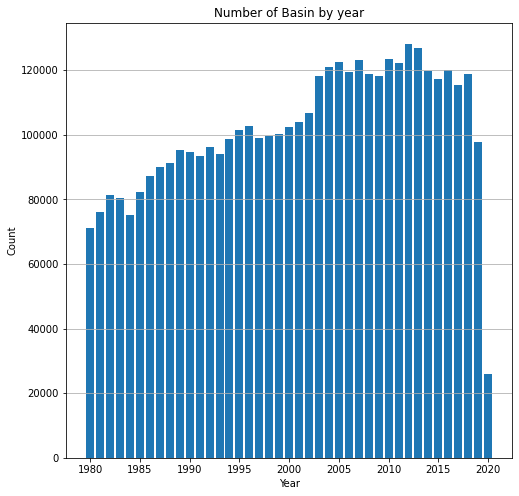

In [28]:
plt.figure(figsize=(8, 8))
plt.bar(df.groupby(df.set_index('date').index.year)['basin_id'].count().index, 
        df.groupby(df.set_index('date').index.year)['basin_id'].count())
plt.grid(axis='y')
plt.title('Number of Basin by year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

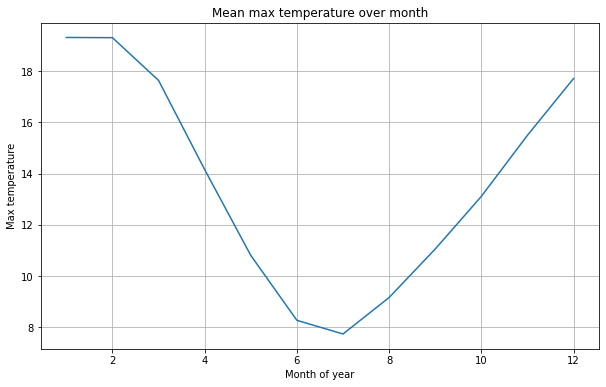

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(df.groupby(df['date'].dt.month)['temp_max'].mean())
plt.grid()
plt.xlabel('Month of year')
plt.ylabel('Max temperature')
plt.title('Mean max temperature over month')
plt.show()


In the absence of a universal definition, heatwaves arebroadly defined as a period of consecutive days where con-ditions are hotter than normal, thereby including seasonallyextreme (i.e. summertime) events, or seasonally anomalouswarm spells (i.e., annual).

Indices used for heatwave or warm spell measurement may involve either percentile or fixed thresholds, include maximum, minimum or apparent temperature, and may focus on either consecutive days where conditions above thethreshold persist or single daily events [e.g.,Meehl andTebaldi, 2004;Alexander et al., 2006]. 

# Lets answer some questions

In [30]:
def normalize_series(series):
    return series/(max(series)-min(series))

In [31]:
def select_variable_timeseries(df: pd.DataFrame,
                               cod_station: int, 
                               variable: str, 
                               min_date: datetime, 
                               max_date: datetime):
    """
    Select timeseries from dataset.
    """
    if variable not in ['flux', 'precip', 'temp_max']:
        raise Exception(f"{variable} is not a valid variable. Choose between 'flux', 'precip' and 'temp_max'.")
    
    idx_station = df['basin_id'] == cod_station
    if sum(idx_station) < 0:
        raise Exception(f"{cod_station} it is not a valid station code.")
    
    idx_date = (df['date'] >= min_date) & (df['date'] <= max_date)
    if sum(idx_date) < 0:
        raise Exception(f"The chosen date interval isnt a valid one.")
        
    return df[(idx_station) & (idx_date)].set_index('date')[variable]

In [32]:
def plot_one_timeserie(cod_station: int, 
                       variable: str, 
                       min_date: datetime, 
                       max_date: datetime):
    
    """
    Timeseries plot of the following variables: 
    'flux', 'precip' and 'temp_max'
    """
    
    variable_series = select_variable_timeseries(df, cod_station, variable, min_date, max_date)
    
    if len(variable_series)>0:
        plt.figure(figsize=(16, 8))
        plt.plot(variable_series)
        plt.title(f"{variable.capitalize()} between {min_date.strftime('%Y-%m-%d')} and {max_date.strftime('%Y-%m-%d')} @ station {cod_station}")
        plt.ylabel(variable)
        plt.xlabel('Date')
        plt.grid()
        plt.show()
    else:
        print(f"The set of chosen variables returned a empty series.")

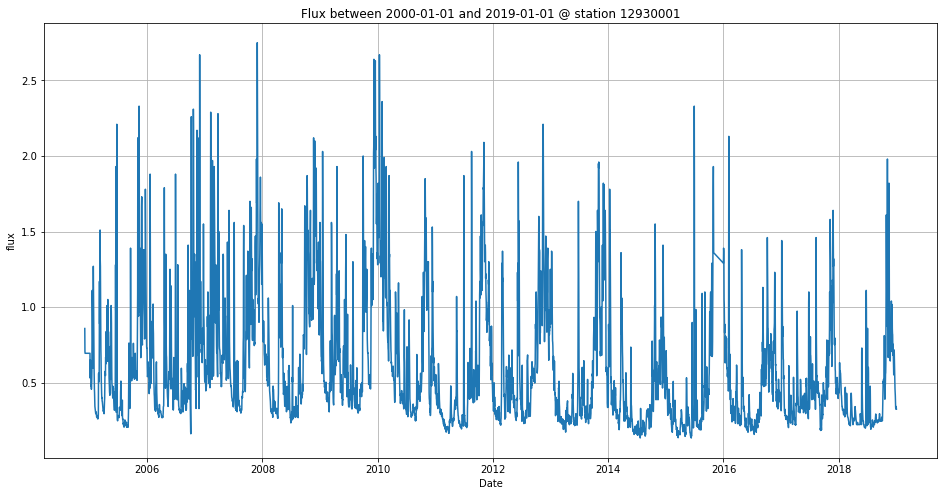

In [33]:
plot_one_timeserie(12930001, 'flux', datetime(2000, 1, 1), datetime(2019, 1, 1))

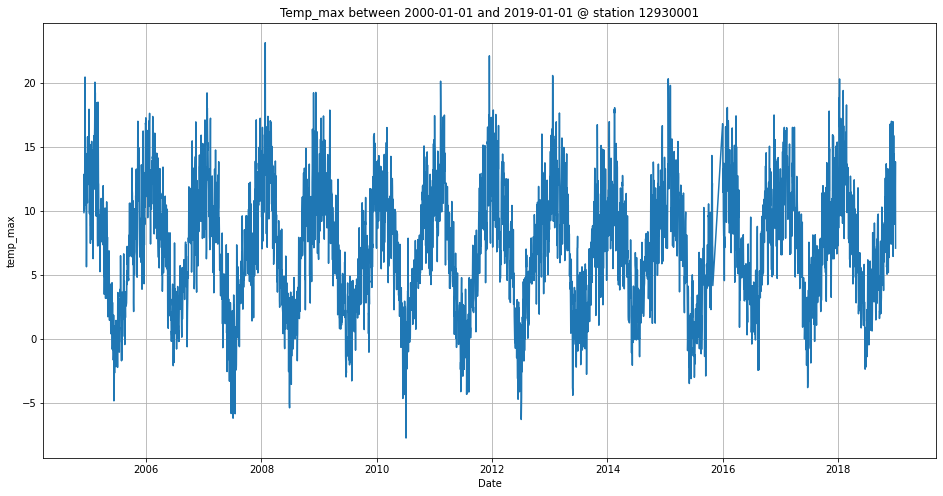

In [34]:
# Classic mean reverting pattern.
plot_one_timeserie(12930001, 'temp_max', datetime(2000, 1, 1), datetime(2019, 1, 1))

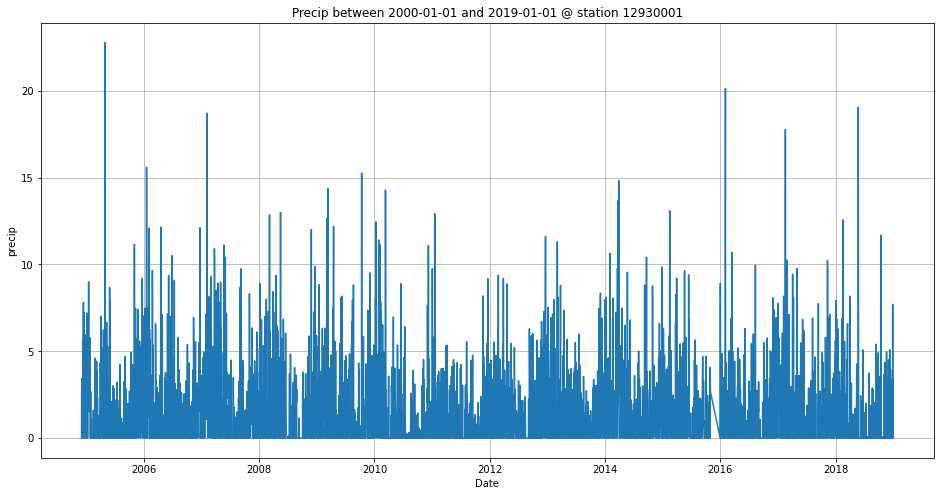

In [35]:
plot_one_timeserie(12930001, 'precip', datetime(2000, 1, 1), datetime(2019, 1, 1))

In [36]:
def plot_three_timeseries(cod_station: int, 
                       min_date: datetime, 
                       max_date: datetime):
    """
    
    """
    
    temp_max_series = select_variable_timeseries(df, cod_station, 'temp_max', min_date, max_date)
    flux_series = select_variable_timeseries(df, cod_station, 'flux', min_date, max_date)
    precip_series = select_variable_timeseries(df, cod_station, 'precip', min_date, max_date)
    
    normalized_temp_max_series = normalize_series(temp_max_series)
    normalized_flux_series = normalize_series(flux_series)
    normalized_precip_series = normalize_series(precip_series)
    
    plt.figure(figsize=(16, 8))
    
    plt.plot(normalized_temp_max_series, label='Max temperature')
    plt.plot(normalized_flux_series, label='Flux')
    plt.plot(normalized_precip_series, label='Preciptation')
    
    plt.xlabel('Date')
    plt.ylabel('Normalized value')
    plt.title(f"Data from station {cod_station} between {min_date.strftime('%Y-%m-%d')} and {max_date.strftime('%Y-%m-%d')} @ ")
    plt.legend()
    plt.show()

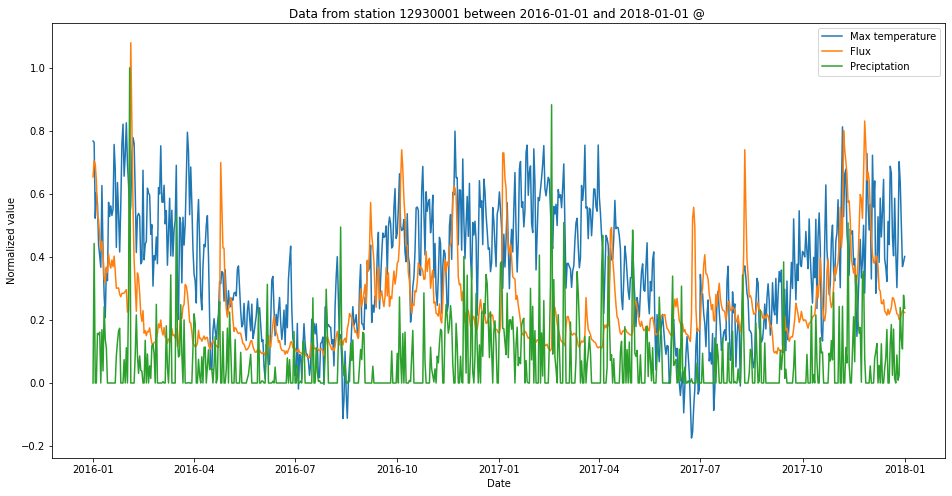

In [37]:
plot_three_timeseries(12930001, datetime(2016, 1, 1), datetime(2018, 1, 1))

## Part IV - Seasonality and extreme events

In [42]:
min_date = df['date'].min()
max_date = df['date'].max()

In [43]:
season_months = {'summer': [12, 1, 2],
                 'autumn': [3, 4, 5],
                 'winter': [6, 7, 8],
                 'spring': [9, 10, 11],
              }

In [46]:
df['season'] = 'aux'

df.loc[df['date'].dt.month.isin(season_months['summer']), 'season'] = 'summer'
df.loc[df['date'].dt.month.isin(season_months['autumn']), 'season'] = 'autumn'
df.loc[df['date'].dt.month.isin(season_months['winter']), 'season'] = 'winter'
df.loc[df['date'].dt.month.isin(season_months['spring']), 'season'] = 'spring'

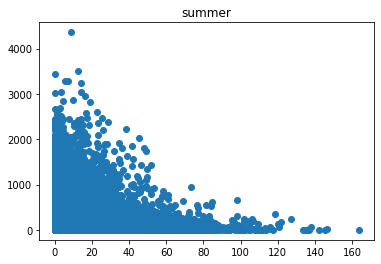

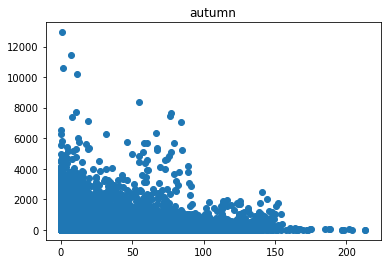

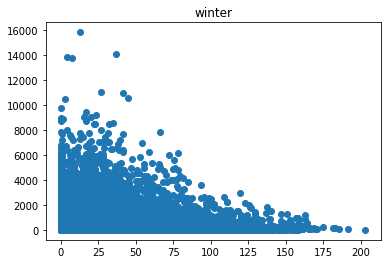

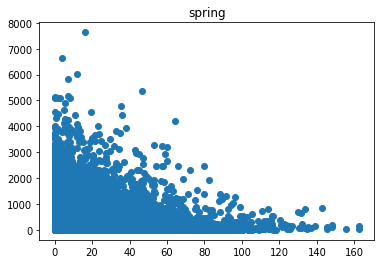

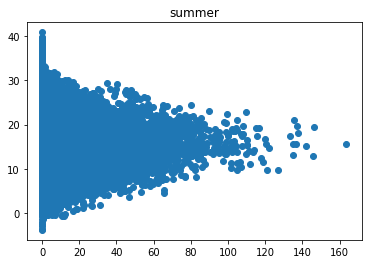

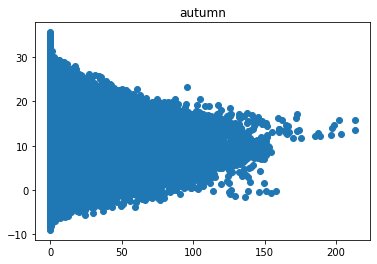

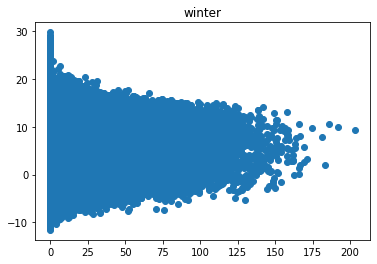

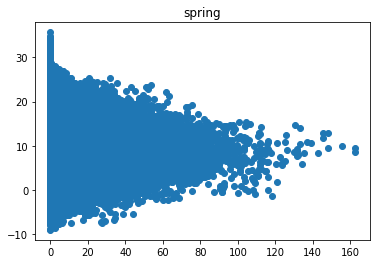

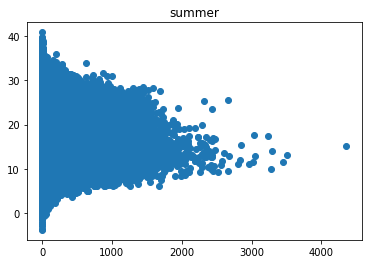

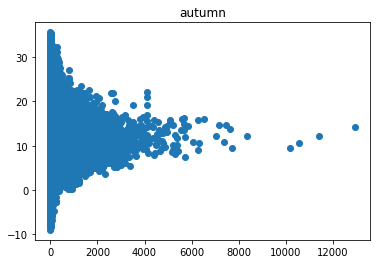

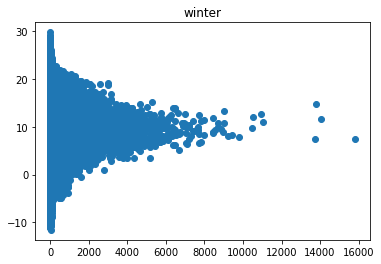

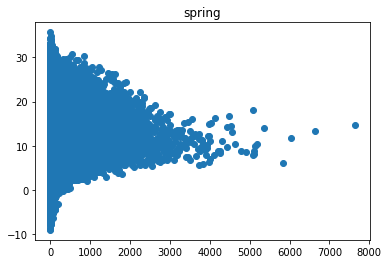

In [47]:
for season in season_months.keys():
    plt.scatter(df[df['season']==season]['precip'], df[df['season']==season]['flux'])
    plt.title(season)
    plt.show()

for season in season_months.keys():
    plt.scatter(df[df['season']==season]['precip'], df[df['season']==season]['temp_max'])
    plt.title(season)
    plt.show()

for season in season_months.keys():
    plt.scatter(df[df['season']==season]['flux'], df[df['season']==season]['temp_max'])
    plt.title(season)
    plt.show()

In [48]:
df['year'] = df['date'].dt.year

In [49]:
def select_variable_timeseries_season(
                                df: pd.DataFrame,
                                cod_station: int, 
                                variable: str, 
                                min_date: datetime, 
                                max_date: datetime,
                                season: str):
    
    return select_variable_timeseries(df[df['season']==season], 
                                      cod_station, variable, 
                                      min_date, max_date)

In [50]:
df.groupby('season')['temp_max'].describe()

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
autumn,1056597.0,14.223340,5.786055,-8.970853,10.182941,13.963813,18.149970,35.546758
spring,1037720.0,13.226321,5.511666,-9.012586,9.419616,12.994946,16.973237,35.673747
summer,1041105.0,18.767318,5.749716,-3.777038,14.118035,18.563586,23.241879,40.811165
winter,1039615.0,8.394771,4.891085,-11.603588,5.048795,8.551136,11.865719,29.798366


Considere a variable value extreme by the "95 percentile" metric its not a good choice. Supose that we have a station with very little variation of temp_max, varying between 20~21. We would classify all the samples with temperature close to 21 like a extreme temperature, when in fact it isnt. 

This vanilla metric dont capture all the information, like standard deviation, inside the distribution.

In [51]:
extreme_quantile_variables = df.groupby(['year', 'season'])[['flux', 'precip', 'temp_max']].quantile(.95)
extreme_quantile_variables.columns = ['quantile_95_'+column for column in extreme_quantile_variables.columns ]
extreme_quantile_variables

quantile_95_flux  quantile_95_precip  quantile_95_temp_max
year season                                                            
1980 autumn         230.00000           36.857574             25.831840
     spring         123.00000            7.664821             23.126047
     summer         106.00000            6.920538             28.514364
     winter         379.10000           31.077582             17.375135
1981 autumn         155.50000           32.281134             25.195295
...                       ...                 ...                   ...
2019 summer         241.00000            6.531030             29.490619
     winter         489.26985           28.452960             15.823998
2020 autumn         415.13850            8.702557             26.286830
     summer         439.88430            7.469192             29.581337
     winter         516.60765                 NaN                   NaN

[163 rows x 3 columns]

In [52]:
df = df.merge(extreme_quantile_variables.reset_index(), on=['year', 'season'], how='left')

In [53]:
df['extreme_temp_max'] = 0
df.loc[df['temp_max'] > df['quantile_95_temp_max'], 'extreme_temp_max'] = 1

df['extreme_flux'] = 0
df.loc[df['flux'] > df['quantile_95_flux'], 'extreme_flux'] = 1

df['extreme_precip'] = 0
df.loc[df['precip'] > df['quantile_95_precip'], 'extreme_precip'] = 1

In [54]:
df[df['season']=='winter'].groupby(['year']).agg({'extreme_temp_max': ['sum', 'count']})

extreme_temp_max       
                  sum  count
year                        
1980              893  17859
1981              964  19276
1982              988  19753
1983              992  19822
1984              886  17706
1985             1031  20612
1986             1064  21263
1987             1116  22307
1988             1140  22794
1989             1209  24169
1990             1197  23924
1991             1154  23081
1992             1163  23257
1993             1142  22828
1994             1248  24948
1995             1265  25284
1996             1277  25533
1997             1233  24658
1998             1248  24957
1999             1276  25510
2000             1270  25399
2001             1303  26056
2002             1311  26209
2003             1478  29553
2004             1515  30297
2005             1530  30597
2006             1479  29564
2007             1572  31439
2008             1466  29307
2009             1498  29948
2010             1589  31763
2011             1557  31135
2012             1626  32512
2013             1603  32042
2014             1575  31495
2015             1462  29222
2016             1529  30569
2017             1452  29032
2018             1464  29263
2019             1234  24672
2020                0    990

In [55]:
df = df[df['year']!=2020]

In [56]:
for station in df['basin_id'].unique():
    for season in df['season'].unique():
        # if p-value is bigger than 0.05 so we fail to reject the null hypothesis
        # then the distribution is normal (it is not)
        if jarque_bera(select_variable_timeseries_season(df, station, 'temp_max', min_date, max_date, season))[1] > 0.05:
            print(station, season, jarque_bera(select_variable_timeseries_season(df, station, 'temp_max', min_date, max_date, season))[1])


1001001 summer 0.5572308318897656
1020002 summer 0.3927464622931546
1041002 summer 0.17392195564456303
1044001 summer 0.06527134975438809
1050004 summer 0.4424957442603976
1201005 summer 0.05752566213654431
1210001 summer 0.6057613206973115
1211001 summer 0.9016636077350677
1300009 summer 0.264318061799661
1310002 summer 0.7894331598889885
1410004 summer 0.1766340170049222
1502008 summer 0.40123116359462563
1610002 summer 0.05868150724903631
1610004 summer 0.574971195831725
1610004 autumn 0.07033243317908888
1730001 winter 0.0557177719028209
1730002 summer 0.10576325702331058
1730003 summer 0.48067419278867207
1730007 summer 0.592485742770277
1730012 summer 0.5741827266956865
2103001 summer 0.7805548953035268
2103002 summer 0.7744332849406814
2103003 summer 0.7657466637151098
2103003 winter 0.6903021946618461
2103014 summer 0.09818800000057659
2104002 summer 0.2969720623040505
2104003 summer 0.11402166884738107
2104013 summer 0.8225221352459338
2105001 summer 0.3873876236495766
2105002

KeyboardInterrupt: 

In [57]:
from scipy.stats import jarque_bera

for year in df['year'].unique()[::-1]:
    for season in df['season'].unique():
        # if p-value is bigger than 0.05 so we fail to reject the null hypothesis
        # then the distribution is normal (it is not)
        if jarque_bera(df[(df['year']==year) & (df['season']==season)]['temp_max'])[1] > 0.05:
            print(season, year, jarque_bera(df[(df['year']==year) & (df['season']==season)]['temp_max'])[1])


autumn 2017 0.15641256322728503


KeyboardInterrupt: 

In [58]:
for variable in ['temp_max', 'flux', 'precip']:
    df[f"{variable}_moving_avg"] = df.groupby('basin_id')[[variable]].rolling(90).mean().reset_index().set_index('level_1')[variable]
    df[f"{variable}_moving_std"] = df.groupby('basin_id')[[variable]].rolling(90).std().reset_index().set_index('level_1')[variable]
    df[f"{variable}_moving_z"] = (df[variable] - df[f"{variable}_moving_avg"])/df[f"{variable}_moving_std"]
    
    df[f"{variable}_extreme"] = 0
    df.loc[df[f"{variable}_moving_z"] > 3, f"{variable}_extreme"] = 1

In [59]:
df.groupby('basin_id')[['temp_max_extreme']].sum().sort_values('temp_max_extreme')

,temp_max_extreme
basin_id,
4810006,0
5420002,0
5411002,0
2110031,0
2112005,0
...,...
8910001,177
11505001,177
11514001,185


In [60]:
station = 10134001

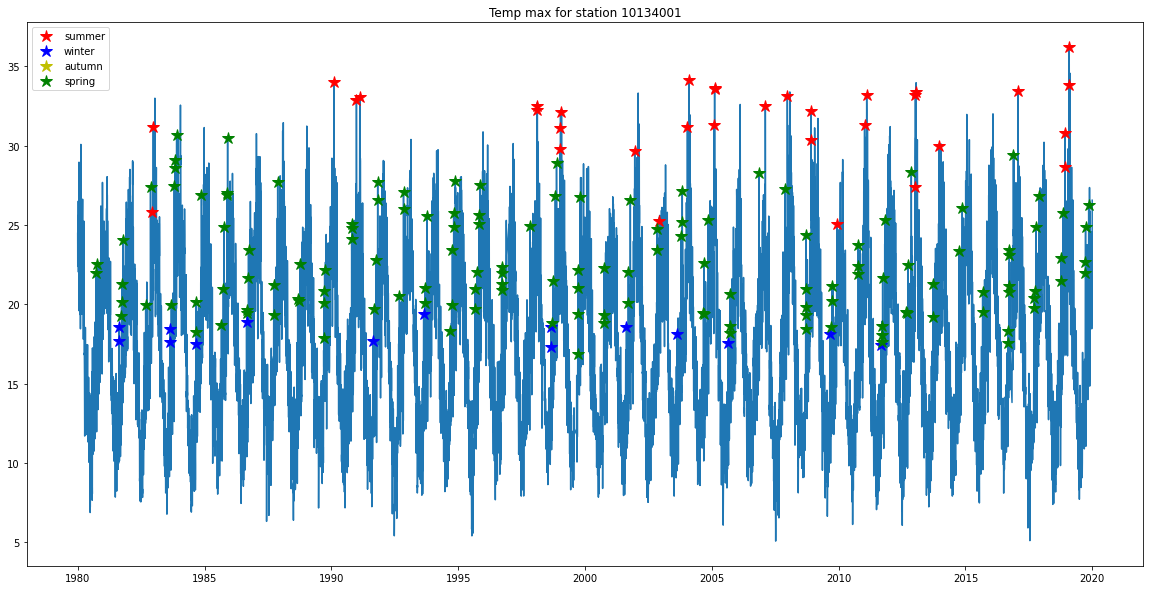

In [61]:
# Ornstein Uhlenbeck mean reverting process

dff2 = df[df['basin_id']==station].copy()

plt.figure(figsize=(20, 10))

plt.plot(dff2.set_index('date')['temp_max'])
plt.plot(dff2[(dff2['season']=='summer') & (dff2['temp_max_extreme']>0)].set_index('date')['temp_max'], 
         'r*', markersize=12, label='summer')
plt.plot(dff2[(dff2['season']=='winter') & (dff2['temp_max_extreme']>0)].set_index('date')['temp_max'], 
         'b*', markersize=12, label='winter')
plt.plot(dff2[(dff2['season']=='autumn') & (dff2['temp_max_extreme']>0)].set_index('date')['temp_max'], 
         'y*', markersize=12, label='autumn')
plt.plot(dff2[(dff2['season']=='spring') & (dff2['temp_max_extreme']>0)].set_index('date')['temp_max'], 
         'g*', markersize=12, label='spring')

plt.title(f'Temp max for station {station}')
plt.legend()
plt.show()

[Ornstein Uhlenbeck](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process):

$ dx_t = \theta (\mu - x_t) dt + \sigma dW_t $

Where:

$dW_t$ is a brownian motion. 

$\mu$ is the mean of the process.

$\sigma$ is the volatility 

$\theta$ represents the "speed" of mean reversion.

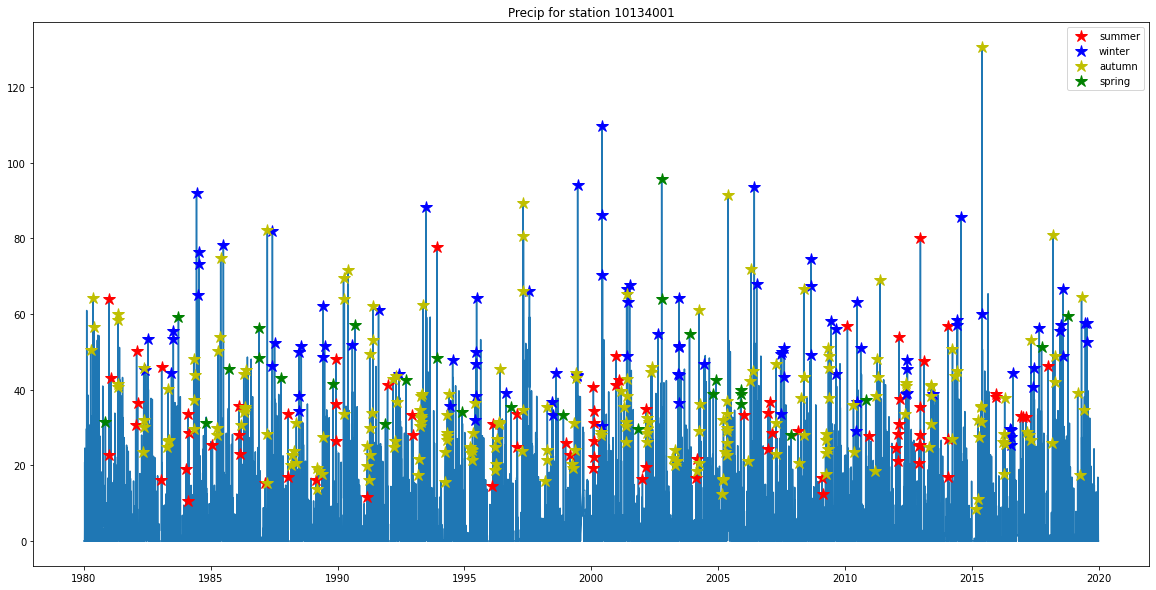

In [62]:
dff2 = df[df['basin_id']==station].copy()

plt.figure(figsize=(20, 10))

plt.plot(dff2.set_index('date')['precip'])
plt.plot(dff2[(dff2['season']=='summer') & (dff2['precip_extreme']>0)].set_index('date')['precip'],
         'r*', markersize=12, label='summer')
plt.plot(dff2[(dff2['season']=='winter') & (dff2['precip_extreme']>0)].set_index('date')['precip'],
         'b*', markersize=12, label='winter')
plt.plot(dff2[(dff2['season']=='autumn') & (dff2['precip_extreme']>0)].set_index('date')['precip'],
         'y*', markersize=12, label='autumn')
plt.plot(dff2[(dff2['season']=='spring') & (dff2['precip_extreme']>0)].set_index('date')['precip'],
         'g*', markersize=12, label='spring')

plt.title(f'Precip for station {station}')
plt.legend()
plt.show()

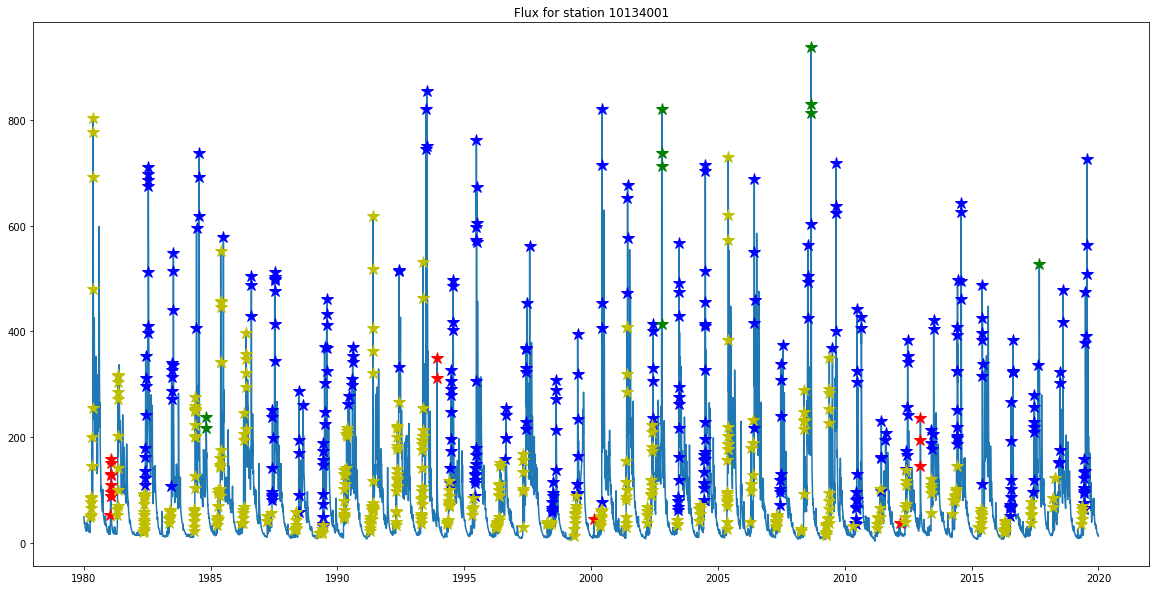

In [63]:
# This is gorgeous. Looks like a hawkes process. (self-exciting process)
dff2 = df[df['basin_id']==station].copy()

plt.figure(figsize=(20, 10))

plt.plot(dff2.set_index('date')['flux'])
plt.plot(dff2[(dff2['season']=='summer') & (dff2['flux_extreme']>0)].set_index('date')['flux'], 'r*', markersize=12)
plt.plot(dff2[(dff2['season']=='winter') & (dff2['flux_extreme']>0)].set_index('date')['flux'], 'b*', markersize=12)
plt.plot(dff2[(dff2['season']=='autumn') & (dff2['flux_extreme']>0)].set_index('date')['flux'], 'y*', markersize=12)
plt.plot(dff2[(dff2['season']=='spring') & (dff2['flux_extreme']>0)].set_index('date')['flux'], 'g*', markersize=12)

plt.title(f'Flux for station {station}')
plt.show()


In [64]:
# Lets do some transformation
df['log_flux'] = np.log(df['flux']+1)

for variable in ['log_flux']:
    df[f"{variable}_moving_avg"] = df.groupby('basin_id')[[variable]].rolling(90).mean().reset_index().set_index('level_1')[variable]
    df[f"{variable}_moving_std"] = df.groupby('basin_id')[[variable]].rolling(90).std().reset_index().set_index('level_1')[variable]
    df[f"{variable}_moving_z"] = (df[variable] - df[f"{variable}_moving_avg"])/df[f"{variable}_moving_std"]
    
    df[f"{variable}_extreme"] = 0
    df.loc[df[f"{variable}_moving_z"] > 3, f"{variable}_extreme"] = 1

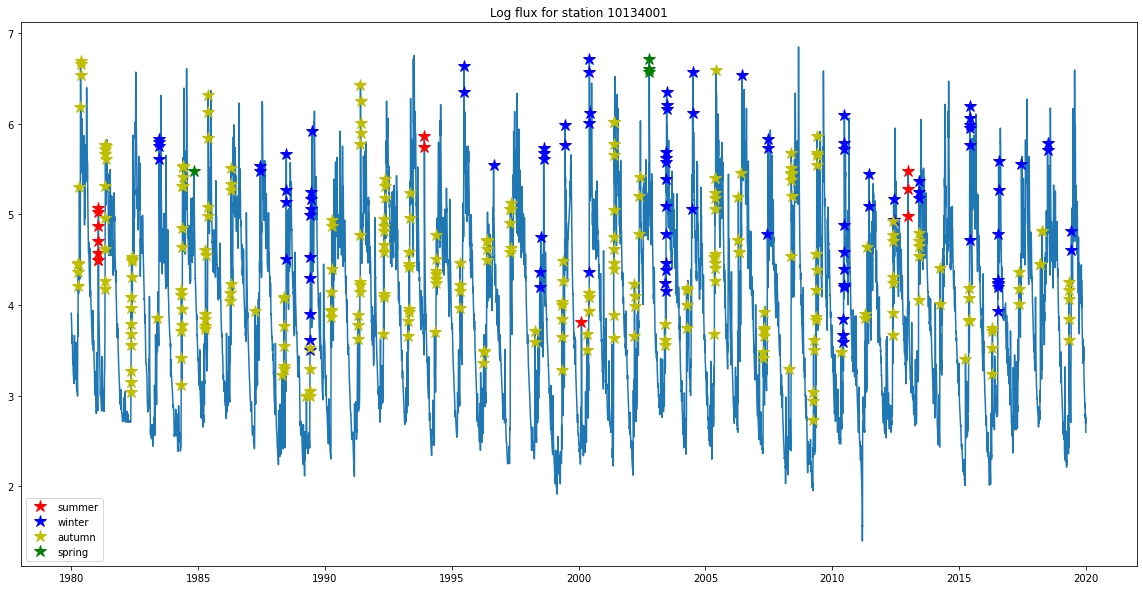

In [65]:
dff2 = df[df['basin_id']==station].copy()
plt.figure(figsize=(20, 10))
plt.plot(dff2.set_index('date')['log_flux'])
plt.plot(dff2[(dff2['season']=='summer') & (dff2['log_flux_extreme']>0)].set_index('date')['log_flux'], 
         'r*', markersize=12, label='summer')
plt.plot(dff2[(dff2['season']=='winter') & (dff2['log_flux_extreme']>0)].set_index('date')['log_flux'], 
         'b*', markersize=12, label='winter')
plt.plot(dff2[(dff2['season']=='autumn') & (dff2['log_flux_extreme']>0)].set_index('date')['log_flux'], 
         'y*', markersize=12, label='autumn')
plt.plot(dff2[(dff2['season']=='spring') & (dff2['log_flux_extreme']>0)].set_index('date')['log_flux'], 
         'g*', markersize=12, label='spring')

plt.title(f'Log flux for station {station}')
plt.legend()
plt.show()


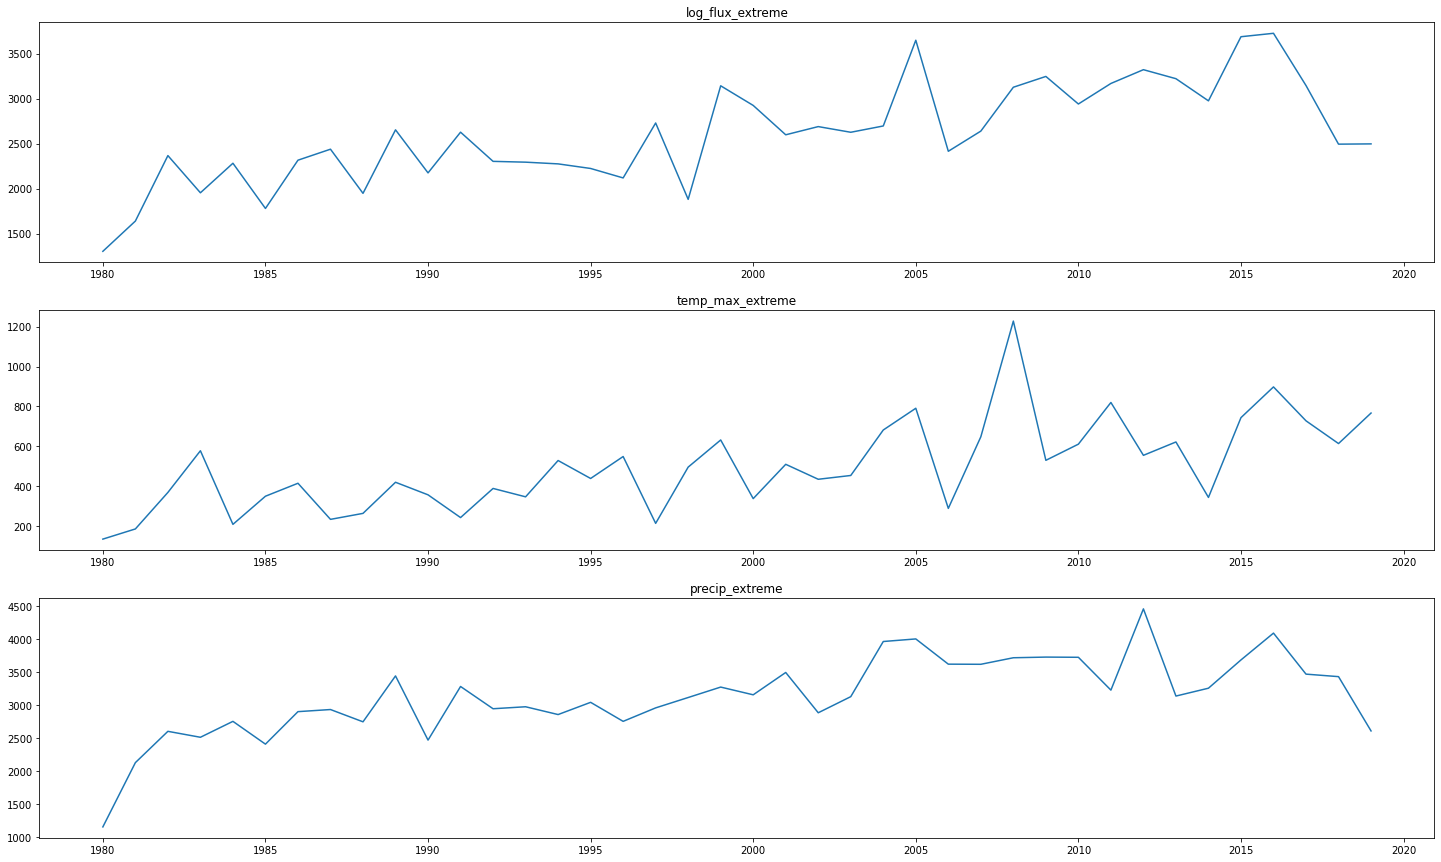

In [66]:
plt.figure(figsize=(25,15))

plt.subplot(3, 1, 1)
plt.plot(df.groupby('year')['log_flux_extreme'].sum())
plt.title('log_flux_extreme')

plt.subplot(3, 1, 2)
plt.plot(df.groupby('year')['temp_max_extreme'].sum())
plt.title('temp_max_extreme')

plt.subplot(3, 1, 3)
plt.plot(df.groupby('year')['precip_extreme'].sum())
plt.title('precip_extreme')

plt.show()

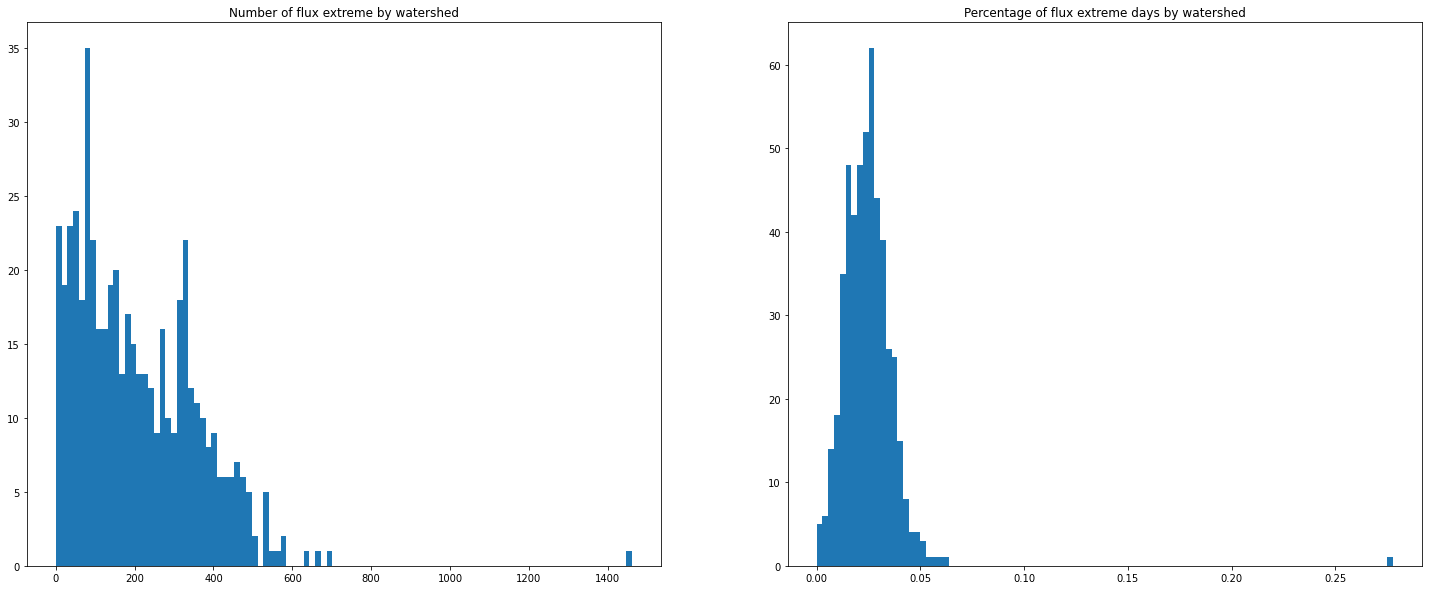

In [67]:
plt.figure(figsize=(25,10))

plt.subplot(1, 2, 1)
plt.hist(df.groupby('basin_id')['log_flux_extreme'].sum(), bins=100)
plt.title('Number of flux extreme by watershed')

plt.subplot(1, 2, 2)
plt.hist(df.groupby('basin_id')['log_flux_extreme'].sum()/df.groupby('basin_id')['log_flux_extreme'].count(), bins=100)
plt.title('Percentage of flux extreme days by watershed')

plt.show()

We can say that half of the watersheds have 2.4% of days with extreme flux.

In [68]:
(df.groupby('basin_id')['log_flux_extreme'].sum()/df.groupby('basin_id')['log_flux_extreme'].count()).describe()

count    503.000000
mean       0.024818
std        0.015251
min        0.000000
25%        0.016669
50%        0.024155
75%        0.030884
max        0.277788
Name: log_flux_extreme, dtype: float64

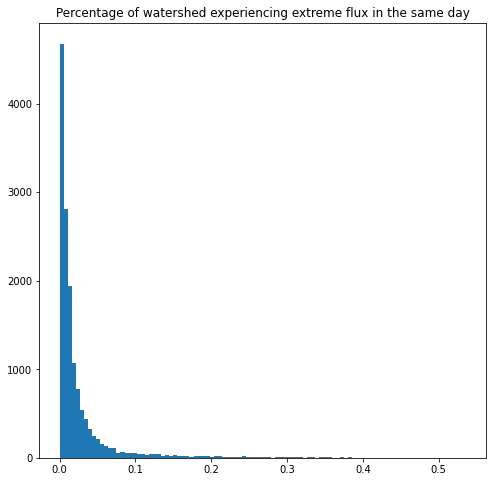

In [69]:
plt.figure(figsize=(8, 8))
plt.hist(df.groupby('date')['log_flux_extreme'].sum()/df.groupby('date')['log_flux_extreme'].count(), bins=100)
plt.title('Percentage of watershed experiencing extreme flux in the same day')
plt.show()

Its expected that 2.5% of watershed's experience extreme flux in the same day. In the past, this number reached a level of 53% of waterhseds experiencing some kind of extreme flux in the same day. 

In [70]:
(df.groupby('date')['log_flux_extreme'].sum()/df.groupby('date')['log_flux_extreme'].count()).describe()

count    14610.000000
mean         0.025069
std          0.047052
min          0.000000
25%          0.003774
50%          0.009975
75%          0.024272
max          0.535433
Name: log_flux_extreme, dtype: float64

In [71]:
flux_extreme_vs_common = pd.pivot_table(df.groupby(['year', 'log_flux_extreme'])[['flux']].mean().reset_index(), 
                                       values='flux', columns='log_flux_extreme', index='year')
flux_extreme_vs_common.columns = ['mean_common_flux', 'mean_flux_extreme']
flux_extreme_vs_common

,mean_common_flux,mean_flux_extreme
year,,
1980,41.409807,83.994796
1981,30.764559,105.653410
1982,45.891881,75.041671
1983,30.970983,94.164075
1984,42.601733,93.776571
1985,37.168934,118.220302
1986,46.872966,122.475038
1987,45.022914,119.531422
1988,32.608493,76.906657


Having a situation of extreme flux, its value is expected to be twice the common value. 

In [72]:
(flux_extreme_vs_common['mean_flux_extreme']/flux_extreme_vs_common['mean_common_flux']).describe()

count    40.000000
mean      2.100063
std       0.662962
min       0.926127
25%       1.604580
50%       1.976692
75%       2.579073
max       3.779789
dtype: float64

Lets analyse the watersheds with the least and most occurrence extreme flux.

In [73]:
df.groupby('basin_id')['log_flux_extreme'].sum().sort_values()[:3]

basin_id
5423002     0
11151001    0
4534001     0
Name: log_flux_extreme, dtype: int64

In [74]:
df.groupby('basin_id')['log_flux_extreme'].sum().sort_values()[-3:]

basin_id
4400001      661
12285001     691
7306001     1462
Name: log_flux_extreme, dtype: int64

Here we can observe some smooth patterns.

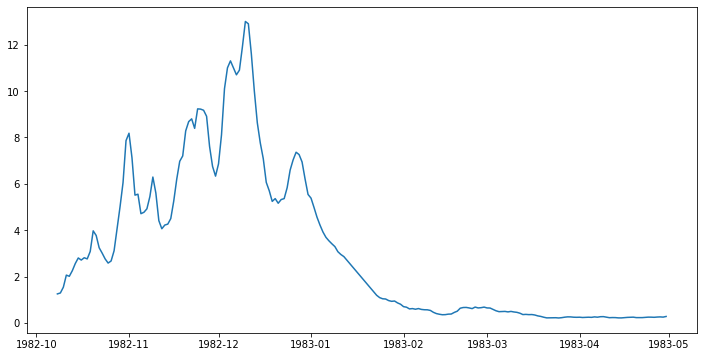

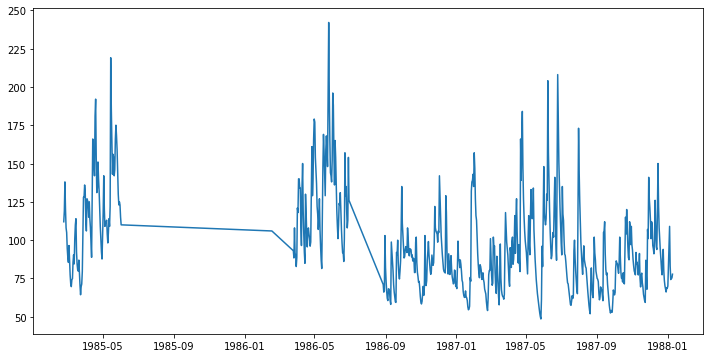

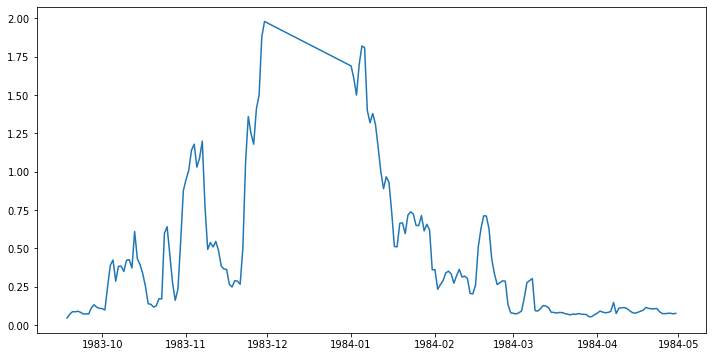

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(select_variable_timeseries(df, 4534001, 'flux', min_date, max_date))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(select_variable_timeseries(df, 11151001, 'flux', min_date, max_date))
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(select_variable_timeseries(df, 5423002, 'flux', min_date, max_date))
plt.show()

In the most common extreme flux watersheds, the flux looks like a self-exciting process.

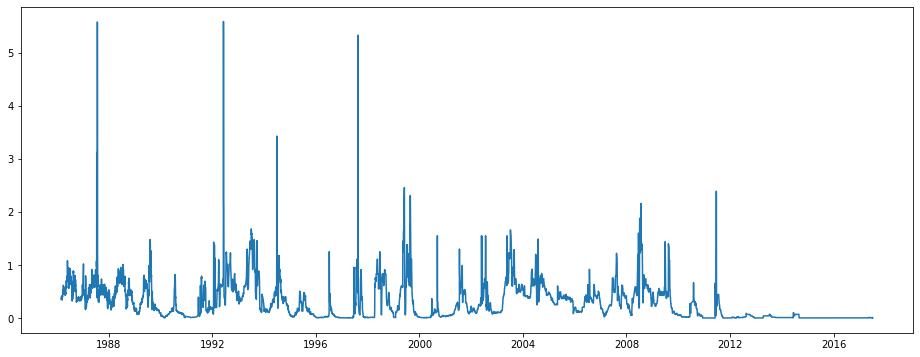

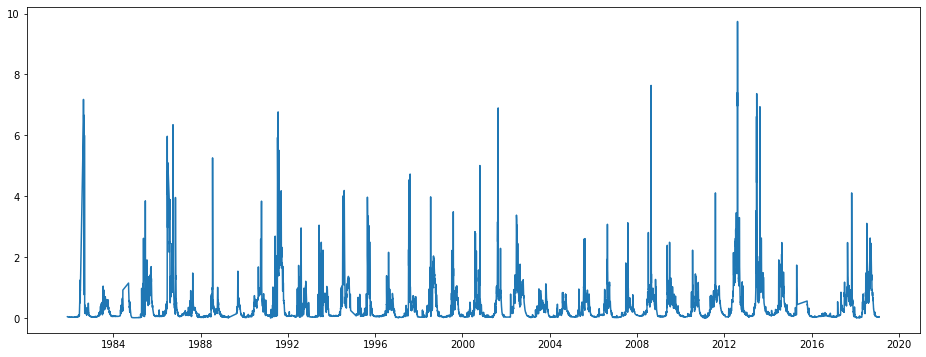

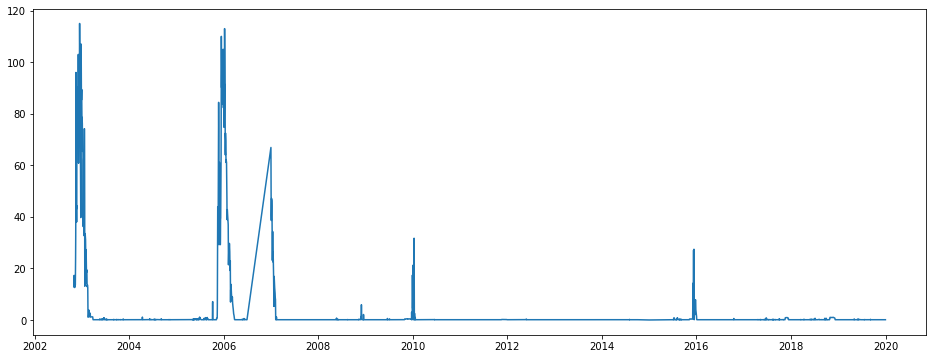

In [76]:
plt.figure(figsize=(16, 6))
plt.plot(select_variable_timeseries(df, 4400001, 'flux', min_date, max_date))
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(select_variable_timeseries(df, 12285001, 'flux', min_date, max_date))
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(select_variable_timeseries(df, 7306001, 'flux', min_date, max_date))
plt.show()

## Extreme flux prediction

In [77]:
df = df.sort_values(['basin_id', 'date'])

In [78]:
trainTest = df.copy()

In [79]:
n_lags = 10

In [80]:
# Features.

for n in range(1, n_lags+1):
    trainTest[f'temp_max_{n}'] = trainTest.groupby('basin_id')['temp_max'].shift(n)
    trainTest[f'flux_{n}'] = trainTest.groupby('basin_id')['flux'].shift(n)
    trainTest[f'log_flux_{n}'] = trainTest.groupby('basin_id')['log_flux'].shift(n)
    trainTest[f'precip_{n}'] = trainTest.groupby('basin_id')['precip'].shift(n)

In [81]:
days_train = 365 * 3

In [82]:
trainTest['log_flux_extreme_dayBefore'] = trainTest.groupby('basin_id')['log_flux_extreme'].shift(1).fillna(0)

In [83]:
trainTest['precip_extreme_dayBefore'] = trainTest.groupby('basin_id')['precip_extreme'].shift(1).fillna(0)

In [84]:
trainTest['temp_max_extreme_dayBefore'] = trainTest.groupby('basin_id')['temp_max_extreme'].shift(1).fillna(0)

#### Bayes-theorem:

$$ P(A | B) = \frac{P(A | B)P(A)}{P(B)}$$

#### This is a important information!!!!!!!

A vanilla model should say that there is 63% chance of the next day of a flux extreme day in a watershed be again a extreme day flux. So this is a important indicator

In [85]:
extreme_flux_index = (trainTest['log_flux_extreme']==1)
extreme_flux_dayBefore_index = (trainTest['log_flux_extreme_dayBefore']==1)
trainTest[extreme_flux_dayBefore_index & extreme_flux_index].shape[0]/trainTest[extreme_flux_dayBefore_index].shape[0]

0.6324249112369255

On the otherside, a day without extreme flux event is NOT a indicator of a next day with extreme flux.

In [86]:
not_extreme_flux_dayBefore_index = (trainTest['log_flux_extreme_dayBefore']!=1)
trainTest[not_extreme_flux_dayBefore_index & extreme_flux_index].shape[0]/trainTest[not_extreme_flux_dayBefore_index].shape[0]

0.009462186558589466

In [87]:
trainTest['log_flux_extreme_5daysBefore'] = trainTest.groupby('basin_id')['log_flux_extreme_dayBefore'].rolling(5).sum().fillna(0).reset_index().set_index('level_1')['log_flux_extreme_dayBefore']

extreme_flux_index = (trainTest['log_flux_extreme']==1)
extreme_flux_5daysBefore_index = (trainTest['log_flux_extreme_5daysBefore']==5)
trainTest[extreme_flux_5daysBefore_index & extreme_flux_index].shape[0]/trainTest[extreme_flux_5daysBefore_index].shape[0]

0.6987343090785978

In [88]:
# 90day moving average for each watershed
for variable in ['temp_max_1', 'flux_1','log_flux_1', 'precip_1']:
    trainTest[f"{variable}_moving_avg"] = trainTest.groupby('basin_id')[[variable]].rolling(90).mean().reset_index().set_index('level_1')[variable]
    trainTest[f"{variable}_moving_std"] = trainTest.groupby('basin_id')[[variable]].rolling(90).std().reset_index().set_index('level_1')[variable]

In [89]:
import lightgbm as lgb

In [90]:
trainTest['rainy_day'] = 0
trainTest.loc[trainTest['precip']>0, 'rainy_day'] = 1

In [91]:
trainTest.columns

Index(['date', 'basin_id', 'flux', 'precip', 'temp_max', 'gauge_name', 'lat',
       'lon', 'mean_elev', 'area_km2', 'season', 'year', 'quantile_95_flux',
       'quantile_95_precip', 'quantile_95_temp_max', 'extreme_temp_max',
       'extreme_flux', 'extreme_precip', 'temp_max_moving_avg',
       'temp_max_moving_std', 'temp_max_moving_z', 'temp_max_extreme',
       'flux_moving_avg', 'flux_moving_std', 'flux_moving_z', 'flux_extreme',
       'precip_moving_avg', 'precip_moving_std', 'precip_moving_z',
       'precip_extreme', 'log_flux', 'log_flux_moving_avg',
       'log_flux_moving_std', 'log_flux_moving_z', 'log_flux_extreme',
       'temp_max_1', 'flux_1', 'log_flux_1', 'precip_1', 'temp_max_2',
       'flux_2', 'log_flux_2', 'precip_2', 'temp_max_3', 'flux_3',
       'log_flux_3', 'precip_3', 'temp_max_4', 'flux_4', 'log_flux_4',
       'precip_4', 'temp_max_5', 'flux_5', 'log_flux_5', 'precip_5',
       'temp_max_6', 'flux_6', 'log_flux_6', 'precip_6', 'temp_max_7',
       'flu

In [92]:
nTrain = int(len(trainTest['date'].unique()) * 0.7)
nTest = int(len(trainTest['date'].unique()) - nTrain)

In [93]:
trainTest['date'].unique()[:nTrain]

array(['1980-01-01T00:00:00.000000000', '1980-01-02T00:00:00.000000000',
       '1980-01-03T00:00:00.000000000', ...,
       '2009-09-09T00:00:00.000000000', '2009-09-10T00:00:00.000000000',
       '2009-09-11T00:00:00.000000000'], dtype='datetime64[ns]')

In [94]:
train = trainTest[trainTest['date'].isin(trainTest['date'].unique()[:nTrain])]
test = trainTest[trainTest['date'].isin(trainTest['date'].unique()[nTrain:])]

In [96]:
X_train = train[['temp_max_1', 'flux_1',
           'precip_1', 'log_flux_1', 'log_flux_extreme_dayBefore', 'temp_max_extreme_dayBefore', 'precip_extreme_dayBefore',
           'log_flux_extreme_5daysBefore', 'temp_max_1_moving_avg',
           'temp_max_1_moving_std', 'flux_1_moving_avg', 'flux_1_moving_std',
           'log_flux_1_moving_avg', 'log_flux_1_moving_std', 'precip_1_moving_avg',
           'precip_1_moving_std', 'temp_max_2', 'flux_2', 'log_flux_2', 'precip_2',
           'temp_max_3', 'flux_3', 'log_flux_3', 'precip_3', 'temp_max_4',
           'flux_4', 'log_flux_4', 'precip_4', 'temp_max_5', 'flux_5',
           'log_flux_5', 'precip_5', 'temp_max_6', 'flux_6', 'log_flux_6',
           'precip_6', 'temp_max_7', 'flux_7', 'log_flux_7', 'precip_7',
           'temp_max_8', 'flux_8', 'log_flux_8', 'precip_8', 'temp_max_9',
           'flux_9', 'log_flux_9', 'precip_9', 'temp_max_10', 'flux_10',
           'log_flux_10', 'precip_10', 'rainy_day']]
y_train = train['log_flux_extreme']

In [98]:
X_test = test[['temp_max_1', 'flux_1',
           'precip_1', 'log_flux_1', 'log_flux_extreme_dayBefore', 'temp_max_extreme_dayBefore', 'precip_extreme_dayBefore',
           'log_flux_extreme_5daysBefore', 'temp_max_1_moving_avg',
           'temp_max_1_moving_std', 'flux_1_moving_avg', 'flux_1_moving_std',
           'log_flux_1_moving_avg', 'log_flux_1_moving_std', 'precip_1_moving_avg',
           'precip_1_moving_std', 'temp_max_2', 'flux_2', 'log_flux_2', 'precip_2',
           'temp_max_3', 'flux_3', 'log_flux_3', 'precip_3', 'temp_max_4',
           'flux_4', 'log_flux_4', 'precip_4', 'temp_max_5', 'flux_5',
           'log_flux_5', 'precip_5', 'temp_max_6', 'flux_6', 'log_flux_6',
           'precip_6', 'temp_max_7', 'flux_7', 'log_flux_7', 'precip_7',
           'temp_max_8', 'flux_8', 'log_flux_8', 'precip_8', 'temp_max_9',
           'flux_9', 'log_flux_9', 'precip_9', 'temp_max_10', 'flux_10',
           'log_flux_10', 'precip_10', 'rainy_day']]
y_test = test['log_flux_extreme']

In [99]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [100]:
lgbm = LGBMClassifier() # Shortname the LGBMClassifier()

lgbm.fit(X_train, y_train) 

LGBMClassifier()

In [102]:
y_test_pred = lgbm.predict(X_test)
score = round(accuracy_score(y_test, y_test_pred), 3) # 
score

0.984

In [103]:
sum(y_test == y_test_pred)

1358491

In [104]:
sum(y_test)

35478

In [105]:
confusion_matrix(y_test, y_test_pred)

array([[1336214,    9049],
       [  13201,   22277]], dtype=int64)

In [106]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        if y_actual[i]==y_hat[i]==0:
            TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return(TP, FP, TN, FN)

In [107]:
measure_metrics = perf_measure(y_test.values, y_test_pred)
measure_metrics

(22277, 9049, 1336214, 13201)

We can use the recall metric to measure the percentage of true events that the model correctly identified.

In [108]:
recall_measure = lambda tp, fn: tp / (tp + fn)

In [109]:
recall_measure(measure_metrics[0] , measure_metrics[3])

0.6279102542420655

In [110]:
y_predProba = lgbm.predict_proba(X_test)[:, 1]

In [111]:
for threshold in np.linspace(0, 1, 20):
    y_predProbaFluxExtreme = pd.Series([0]*len(X_test))
    y_predProbaFluxExtreme[y_predProba>threshold] = 1
    measure_metrics = perf_measure(y_test.values, y_predProbaFluxExtreme.values)
    print(threshold, np.round(recall_measure(measure_metrics[0] , measure_metrics[3]), 3))

0.0 1.0
0.05263157894736842 0.879
0.10526315789473684 0.83
0.15789473684210525 0.798
0.21052631578947367 0.773
0.2631578947368421 0.751
0.3157894736842105 0.731
0.3684210526315789 0.708
0.42105263157894735 0.68
0.47368421052631576 0.648
0.5263157894736842 0.607
0.5789473684210527 0.56
0.631578947368421 0.5
0.6842105263157894 0.415
0.7368421052631579 0.315
0.7894736842105263 0.235
0.8421052631578947 0.168
0.894736842105263 0.104
0.9473684210526315 0.038
1.0 0.0
